In [1]:
# Import the dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Visualize the Stations
sel=[Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
stations = session.query(*sel).all()
for station in stations:
    print(station)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


In [11]:
# Visualize some rows of Measurement
sel=[Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
measurements = session.query(*sel).limit(10).all()
for measurement in measurements:
    print(measurement)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
(6, 'USC00519397', '2010-01-07', 0.06, 70.0)
(7, 'USC00519397', '2010-01-08', 0.0, 64.0)
(8, 'USC00519397', '2010-01-09', 0.0, 68.0)
(9, 'USC00519397', '2010-01-10', 0.0, 73.0)
(10, 'USC00519397', '2010-01-11', 0.01, 64.0)


# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
last_date = last_date[0][0]
last_date = dt.date( int(last_date.split("-")[0]), 
                     int(last_date.split("-")[1]),
                     int(last_date.split("-")[2]) 
                   )
# Calculate the date to filter one year
dt_filter = last_date - dt.timedelta(days=364)


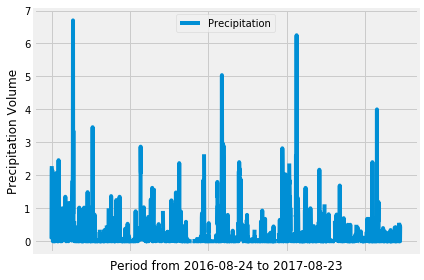

In [13]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
prcp_last_12_months = session.query(*sel).\
    filter(Measurement.date >= dt_filter.strftime("%Y-%m-%d")).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_last_12_months, columns=['date','prcp'])
df.rename(columns = {"prcp": "Precipitation"}, inplace = True)

# Sort the dataframe by date
df.sort_values('date', inplace=True)

#Set the index to the date column
df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.ylabel("Precipitation Volume")
plt.xlabel("Period from " + str(dt_filter) + " to " + str(last_date))
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()


In [14]:
# Print the summary statistics for the precipitation data.
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis 

In [15]:
# Query to show how many stations are available in this dataset?
sel = [func.count(func.distinct(Station.station)).label("number_of_stations")]
total_stations = session.query(*sel).all()
print(total_stations[0].number_of_stations)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,  
      func.count(Measurement.station)]
count_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station in count_station:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_id = count_station[0].station

sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)
      ]
stats_most_active_station = session.query(*sel).\
    filter(Measurement.station == most_active_station_id).\
    group_by(Measurement.station).all()
    
print(stats_most_active_station)


[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the temperatures 
temperatures = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id,
    Measurement.date >= dt_filter.strftime("%Y-%m-%d")).all() 

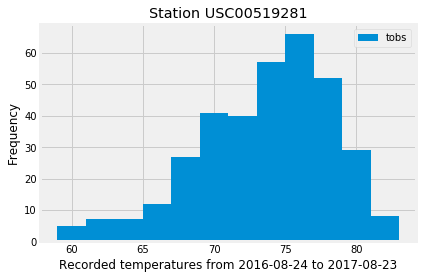

In [19]:
# Plot the histogram
df_temp = pd.DataFrame(temperatures)
df_temp.plot.hist(bins=12)
plt.xlabel('Recorded temperatures from ' + str(dt_filter) + " to " + str(last_date))
plt.ylabel('Frequency')
plt.title('Station ' + most_active_station_id)
plt.grid(True)
plt.show()

In [20]:

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs).label("minimum"),  
                         func.avg(Measurement.tobs).label("average"),  
                         func.max(Measurement.tobs).label("maximum")) .\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Define my period to trip
trip_start = dt.date(2017, 8, 1)  
trip_end = dt.date(2017, 8, 14) 

# Back one year
prev_start = trip_start - dt.timedelta(days=365)
prev_end = trip_end - dt.timedelta(days=365)

# Calc Temps
stats_temp_trip = calc_temps(prev_start, prev_end) 
print (stats_temp_trip)


[(71.0, 78.21111111111111, 83.0)]


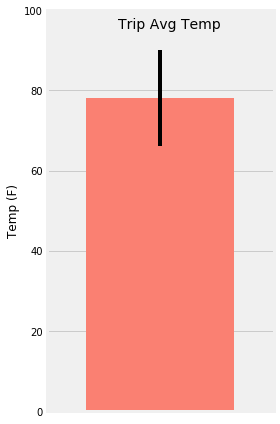

In [22]:
# Plot the results from your previous query as a bar chart.
fig, ax = plt.subplots(figsize=(4,6))

# Use "Trip Avg Temp" as your Title
fig.suptitle("Trip Avg Temp", fontsize=14, fontweight="light", x=0.6, y=0.95)

# Use the average temperature for the y value
y = stats_temp_trip[0].average
x = 0

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_err = stats_temp_trip[0].maximum - stats_temp_trip[0].minimum

ax.set_ylabel("Temp (F)")

ax.bar(x, y, width=1.3, color="salmon", yerr=y_err)
ax.set_ylim(0, 100)
ax.set_xticks([])
ax.set_xbound(lower=-1, upper=1)
plt.grid(True)
fig.tight_layout()
plt.show()


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,
       Station.name, 
       Station.latitude, 
       Station.longitude,
       Station.elevation]

rainfall = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= prev_start).\
    filter(Measurement.date <= prev_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for row in rainfall: 
    print (row)


('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
dates=[]
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date


curr_date = prev_start
print(type(prev_start))
print(type(curr_date))

while (curr_date <= prev_end):
        curr_results = daily_normals( func.strftime("%m-%d", curr_date) )
        normals.append(curr_results[0])
        dates.append(str(curr_date))
        curr_date += dt.timedelta(days=1)
        
for normal in normals:
    print(normal)



<class 'datetime.date'>
<class 'datetime.date'>
(67.0, 75.54, 83.0)
(68.0, 75.60377358490567, 84.0)
(70.0, 76.61111111111111, 85.0)
(69.0, 76.71153846153847, 84.0)
(69.0, 76.14814814814815, 82.0)
(67.0, 76.25, 83.0)
(71.0, 77.15686274509804, 83.0)
(68.0, 76.5576923076923, 83.0)
(69.0, 75.98039215686275, 81.0)
(65.0, 76.42, 83.0)
(67.0, 75.98113207547169, 82.0)
(67.0, 76.52727272727273, 83.0)
(71.0, 76.98245614035088, 84.0)
(71.0, 76.77777777777777, 82.0)


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df_final = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], \
                          index=pd.date_range(start=prev_start, end=prev_end, freq='D'))
#                           index=pd.date_range(start=str(prev_start), end=str(prev_end), freq='D'))



# df_normals = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
# df_dates = pd.DataFrame(dates, columns=['date'])
# df_final = pd.merge(df_normals, df_dates, right_index=True, left_index=True)
# df_final.set_index('date', inplace=True)
df_final

,tmin,tavg,tmax
2016-08-01,67.0,75.540000,83.0
2016-08-02,68.0,75.603774,84.0
2016-08-03,70.0,76.611111,85.0
2016-08-04,69.0,76.711538,84.0
2016-08-05,69.0,76.148148,82.0
2016-08-06,67.0,76.250000,83.0
2016-08-07,71.0,77.156863,83.0
2016-08-08,68.0,76.557692,83.0
2016-08-09,69.0,75.980392,81.0
2016-08-10,65.0,76.420000,83.0


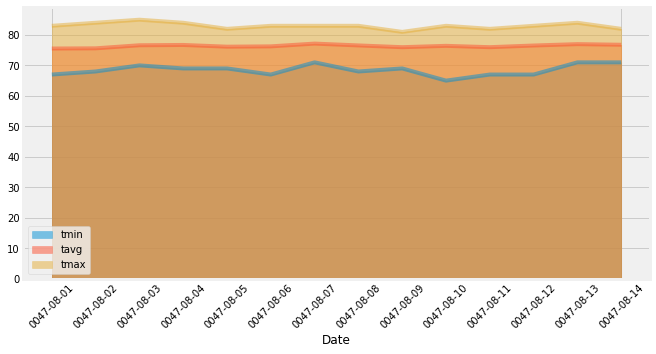

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
import matplotlib.dates as mdates

fign, ax1 = plt.subplots(figsize=(10,5))

df_final.plot(ax=ax1,kind='area', stacked=False, use_index=True,  rot=45, grid=True,sharex=True)
plt.xlabel('Date')

ax1.set_xticklabels(dates)
# ax1.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])



# xticks=list(df_final.index),
# ax1.set_xticks(list(df_final.index))

ax1.xaxis_date()

date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_fmt)
ax1.xaxis.set_minor_formatter(date_fmt)
# _=plt.xticks(rotation=45)  



# ax1.grid(True)

# ax1.set_xticks(fontsize="small", rotation=45)





In [28]:
list(df_final.index)

[Timestamp('2016-08-01 00:00:00', freq='D'),
 Timestamp('2016-08-02 00:00:00', freq='D'),
 Timestamp('2016-08-03 00:00:00', freq='D'),
 Timestamp('2016-08-04 00:00:00', freq='D'),
 Timestamp('2016-08-05 00:00:00', freq='D'),
 Timestamp('2016-08-06 00:00:00', freq='D'),
 Timestamp('2016-08-07 00:00:00', freq='D'),
 Timestamp('2016-08-08 00:00:00', freq='D'),
 Timestamp('2016-08-09 00:00:00', freq='D'),
 Timestamp('2016-08-10 00:00:00', freq='D'),
 Timestamp('2016-08-11 00:00:00', freq='D'),
 Timestamp('2016-08-12 00:00:00', freq='D'),
 Timestamp('2016-08-13 00:00:00', freq='D'),
 Timestamp('2016-08-14 00:00:00', freq='D')]

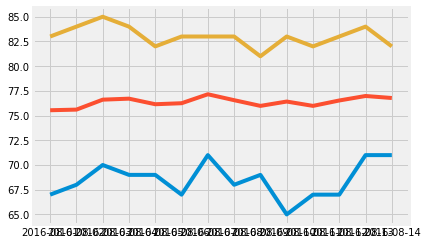

In [29]:
fig2, ax2 = plt.subplots()
ax2.plot(df_final.index, df_final.values)
ax2.set_xticks(df_final.index)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
# _=plt.xticks(rotation=45)   


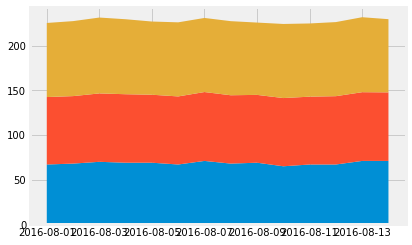

In [30]:
fig3, ax = plt.subplots()
ax.stackplot(df_final.index, \
             [list(df_final['tmin']),list(df_final['tavg']),list(df_final['tmax'])], \
             labels=list(df_final.columns))
# ax.set_title('Combined debt growth over time')
# ax.legend(loc='upper left')
# ax.set_ylabel('Total debt')
# ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])

# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
# _=plt.xticks(rotation=45)   

# fig3.tight_layout()


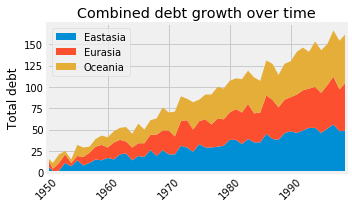

In [31]:
rng = np.arange(50)
rnd = np.random.randint(0, 10, size=(3, rng.size))
yrs = 1950 + rng
fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
_=plt.xticks(rotation=45)   
fig.tight_layout()


In [32]:
yrs

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999])

In [33]:
print(list(df_normals.columns))

NameError: name 'df_normals' is not defined

In [ ]:
[[0 3 3 3 3 7 6 8 4 3 9 4 5 0 1 4 3 0 3 7 1 9 0 2 6 9 4 6 2 8 6 2 5 3 4 6
  8 8 1 0 2 8 1 3 9 8 0 3 6 9]
 [7 7 0 0 3 1 9 7 5 0 2 2 4 2 7 5 2 8 2 8 6 1 7 1 6 9 4 9 6 1 4 1 8 6 3 2
  1 9 5 4 6 5 4 3 1 3 0 0 1 9]
 [0 4 5 0 4 9 3 5 7 2 0 6 3 0 9 9 6 5 9 9 8 8 8 2 3 8 0 7 8 7 4 2 2 1 7 2
  3 6 6 1 2 7 7 7 8 9 2 0 8 0]]